In [92]:

import uproot
import awkward as ak
import numpy as np
import vector
import math
from ipywidgets import interact, FloatSlider

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import norm

%matplotlib widget


e_mass = 511
r_e = 2.817e-15


def process_root_file(file_location):
   
    file = uproot.open(file_location)
    #tree = file["filteredPhoton"]
    tree = file["Hits"]
    branches = ["eventID", "processName", "rsectorID","edep", "posX", "posY", "posZ", 
            "sourcePosX", "sourcePosY", "sourcePosZ"]
    # branches = ["eventID","rsectorID", "processName", "edep", "posX", "posY", "posZ", 
    #         "sourcePosX", "sourcePosY", "sourcePosZ"]
    data = tree.arrays(branches,library="ak")

    print(f"Number of rows in the data: {len(data['processName'])}")

    meta = {}
    if "Metadata" in file:
        metadata_tree = file["Metadata"]
        meta_arrays = metadata_tree.arrays(library="np")
        meta = {k: v[0] if v.size == 1 else v for k, v in meta_arrays.items()}
        print("✅ Metadata loaded.")
    else:
        print("⚠️ No Metadata tree found.")

    return data, meta

def dr1_i(r1, delta, component='x'):
    if component not in ['x', 'y', 'z']:
        raise ValueError("Component must be 'x', 'y', or 'z'.")
    
    r1_comp = getattr(r1, component)
    delta_comp = getattr(delta, component)
    C_theta = (r1).dot(delta)/(r1.mag * delta.mag )
    S_theta = np.sqrt(1 - C_theta**2)

    #factor = ((r1.mag2 * r2.mag2 - (r1.dot(r2))**2 + 1e-8  )**(-0.5))
    #print(f"factor: {factor}")
    # NUM = delta_comp * r1.mag2 * delta.dot(r2) - r1_comp * delta.mag2 * r1.dot(r2)
    # DEN = np.sin(delta.theta) * (delta.mag**3) * (r1.mag**3)
    NUM   = -r1_comp * (r1).dot(delta) * delta.mag2 + (delta_comp - r1_comp) * delta.mag2 * r1.mag2  + delta_comp * (r1).dot(delta) * r1.mag2 
    #DEN  = np.sin(delta.theta) * (delta.mag**3) * ((r1).mag**3)
    DEN   = S_theta * (delta.mag**3) * ((r1).mag**3) 

    return   NUM/DEN

def dr2_i(r1,delta,component= 'x'):
    if component not in ['x', 'y', 'z']:
        raise ValueError("Component must be 'x', 'y', or 'z'.")
    
    r1_comp = getattr(r1, component)
    delta_comp = getattr(delta, component)
    C_theta = (r1).dot(delta)/(r1.mag * delta.mag )
    S_theta = np.sqrt(1 - C_theta**2)

    NUM = r1_comp * delta.mag2 - (delta_comp) * r1.dot(delta) 
    #DEN = np.sin(delta.theta) * (delta.mag**3) * (r1.mag)
    DEN = S_theta * (delta.mag**3) * (r1.mag)
    
    return NUM/DEN

def sigma_theta(r1,delta, sigma_par, sigma_perp):
    
    d_sigma = (
        sigma_par**2  * dr1_i(r1, delta, 'x')**2 +
        sigma_par**2  * dr1_i(r1, delta, 'y')**2 +
        sigma_perp**2 * dr1_i(r1, delta, 'z')**2 +

        sigma_par**2  * dr2_i(r1, delta, 'x')**2 +
        sigma_par**2  * dr2_i(r1, delta, 'y')**2 +
        sigma_perp**2 * dr2_i(r1, delta, 'z')**2  
    )
    
    return np.degrees(d_sigma**0.5)

def d_delE(delE,meta):
    E_i = meta['sourceEnergy']
    factor = E_i / e_mass
    NUM = E_i
    DEN =  (E_i - delE)*np.sqrt( 2* E_i * delE * factor - (delE**2) * (1+ 2*factor) )
    return NUM/DEN

def sigma_beta(delE,sigma_E,meta):
    return np.degrees(np.abs(d_delE(delE,meta)) * sigma_E)

def sigma_D(r1,delta,delE, 
            Theta,Beta,
            sigma_par,sigma_perp,sigma_E,meta):

    sigma_theta_val = sigma_theta(r1,delta,sigma_par,sigma_perp)
    sigma_beta_val = sigma_beta(delE,sigma_E,meta)
    
    return r1.mag * np.abs(np.cos(np.radians(Theta - Beta) )) * np.radians( np.sqrt(sigma_theta_val**2 + sigma_beta_val**2))

In [93]:


#data,meta = process_root_file('root_files/filtered/F_center_511keV_100MBq.root')
#data,meta = process_root_file('root_files/filtered/F_center_750keV_100MBq.root')
#data,meta = process_root_file('root_files/filtered/F_center_1MeV_100MBq.root')

#data,meta = process_root_file('root_files/filtered/F_cylinder_200MBq.root')
data,meta = process_root_file('root_files/beam_9cm/filtered/Fl_1_phi_511keV_2MBq.root')
# meta['sourceEnergy']

Number of rows in the data: 1590926
✅ Metadata loaded.


In [ ]:

r0     = vector.array({"x": data["sourcePosX"][::2], "y": data["sourcePosY"][::2], "z": data["sourcePosZ"][::2]}) 
r1     = vector.array({"x": data["posX"][::2], "y": data["posY"][::2], "z": data["posZ"][::2]})    #Compton events
r2     = vector.array({"x": data["posX"][1::2], "y": data["posY"][1::2], "z": data["posZ"][1::2]}) #Photoelectric events

r1_s   = r1-r0
delta  = (r2-r1)
process_name = data['processName'][1::2]



#Local coordinates
delta_loc  = delta.rotateZ(-r1.phi).rotateY(-r1.theta)
r1_s_loc   = r1_s.rotateZ(-r1.phi).rotateY(-r1.theta)
r2_loc     = r2.rotateZ(-r1.phi).rotateY(-r1.theta)


# Calculate the energy deposited in the Compton event
E_i = meta['sourceEnergy']
compt_shoulder = 2/(2 + e_mass/E_i) * E_i
print(compt_shoulder)
edep1 = data['edep'][::2] * 1000
edep2 = data['edep'][1::2] * 1000

C_beta    = (E_i - edep1*(1 + e_mass/E_i))/(E_i-edep1)
beta       = np.degrees(np.acos(C_beta))


# theta = np.degrees(delta_loc.theta)
theta = np.degrees(np.acos((r1_s).dot(delta)/(r1_s.mag * delta.mag )))

#filt_0 = (delta.mag > 0.1)
filt_0 = ((delta.mag > 0.1)  &
         (data['rsectorID'][::2] == data['rsectorID'][1::2])  &
         ((process_name == 'phot') | (process_name == 'compt')) ) 



# Filter for events with a large angle and same sector
#filt_0 = (data['rsectorID'][::2] == data['rsectorID'][1::2]) & (edep1< 340.66) & (delta_loc.mag> 0.01)




340.66666666666663


## Setting $\sigma_E, \sigma_\perp, \sigma_\parallel$

In [68]:
sigma_E        = 25
sigma_perp     =1.3      #1.3       
sigma_par      = 0.35      # 1.3/sqrt(12)


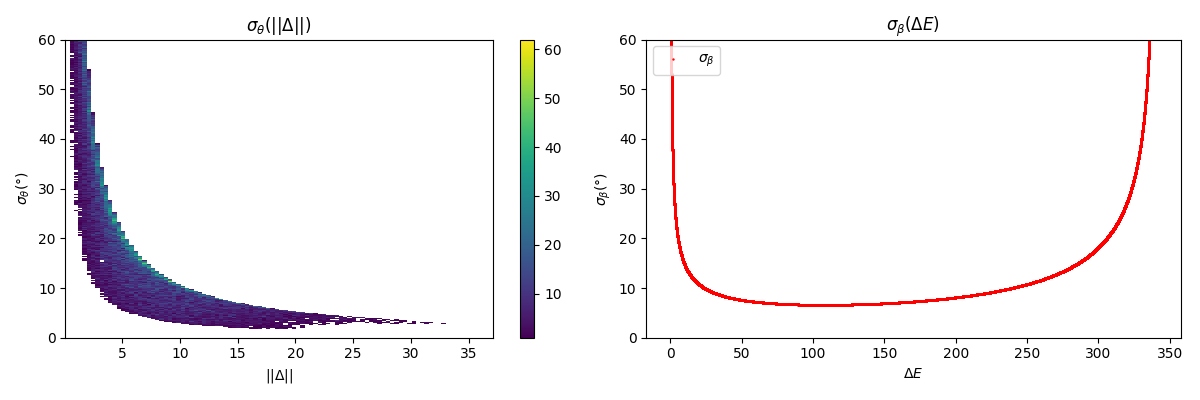

In [85]:
# plot sigma dependecies
sigma_th = sigma_theta(r1_s_loc[filt_0],delta_loc[filt_0],sigma_par,sigma_perp)
sigma_be = sigma_beta(edep1[filt_0], sigma_E, meta)

plt.clf()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# axs[0].scatter(delta_loc.mag[filt_0],sigma_th, s=0.5, alpha = 1, label = r'$\sigma_\theta$')

h = axs[0].hist2d(delta_loc.mag[filt_0],sigma_th, bins=(100,100000), cmap='viridis', cmin=1)
axs[0].set_ylim(0, 60)
fig.colorbar(h[3], ax=axs[0])
#axs[0].scatter(delta_loc.mag[filt_0],sigma_th, s=0.5, alpha = 1, label = r'$\sigma_\theta$')
axs[0].set_xlabel(r'$||\Delta||$')
axs[0].set_ylabel(r'$\sigma_\theta(°)$')
axs[0].set_title(r'$\sigma_\theta(||\Delta||)$')

axs[1].scatter(edep1[filt_0],sigma_be, s=0.5,alpha = 1,color = 'red',label = r'$\sigma_\beta$')
axs[1].set_ylim(0, 60)
axs[1].legend(loc = 'upper left')
#axs[1].set_yscale('log')

axs[1].set_xlabel(r'$\Delta E$')
axs[1].set_ylabel(r'$\sigma_\beta(°)$')
axs[1].set_title(r'$\sigma_\beta(\Delta E)$')
#fig.savefig("sigma_dependecies.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## Setting thresholds $\lvert \lvert \Delta \rvert \rvert , \Delta E_{min}, \Delta E_{max}$

In [87]:
del_min   = 10
E_min     = 50
E_max     = 270
filt = (delta_loc.mag >del_min)  &  (edep1 > E_min)  & (edep1 < E_max) & filt_0


percentage = 100 * ak.sum(filt) / len(filt)
print(f" {ak.sum(filt):.2e}/{len(filt):.2e}, {percentage:.2f}% of events passed the filter")

 7.88e+04/7.95e+05, 9.91% of events passed the filter


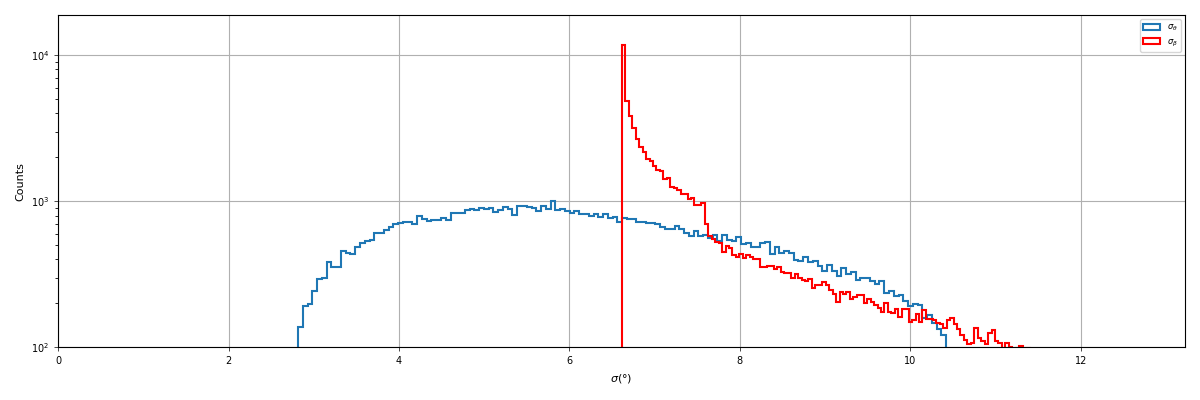

In [ ]:
sigma_th = sigma_theta(r1_s_loc[filt],delta_loc[filt],sigma_par,sigma_perp)
sigma_be = sigma_beta(edep1[filt], sigma_E, meta)

# Convert awkward arrays to NumPy if needed
sigma_th = np.asarray(sigma_th)
sigma_be = np.asarray(sigma_be)

# Compute statistics
mean_th = np.mean(sigma_th)
std_th = np.std(sigma_th)
mean_be = np.mean(sigma_be)
std_be = np.std(sigma_be)

# Plot
plt.clf()
plt.hist(sigma_th, bins=150, histtype='step', linewidth=1.5,
         label=fr'$\sigma_\theta$')
plt.hist(sigma_be, bins=150, histtype='step', linewidth=1.5, color='red',
         label=fr'$\sigma_\beta$')

plt.xlabel(r'$\sigma$(°)', fontsize=8)
plt.tick_params(axis='both', labelsize=7, length=3, width=0.5)
plt.ylabel('Counts', fontsize=8)
plt.grid()
plt.yscale('log')
plt.ylim(bottom=100)
plt.xlim(left=0)

plt.legend(fontsize=6)
plt.tight_layout()
plt.savefig("sigma_comparison.pdf")
plt.show()

In [200]:
r_filt = ((r0.mag > 0) & (r0.mag<10)) & (filt)
percentage = 100 * ak.sum(r_filt) / len(r_filt)
print(f" {ak.sum(r_filt):.2e}/{len(r_filt):.2e}, {percentage:.2f}% of events passed the filter")


 1.23e+02/1.78e+07, 0.00% of events passed the filter


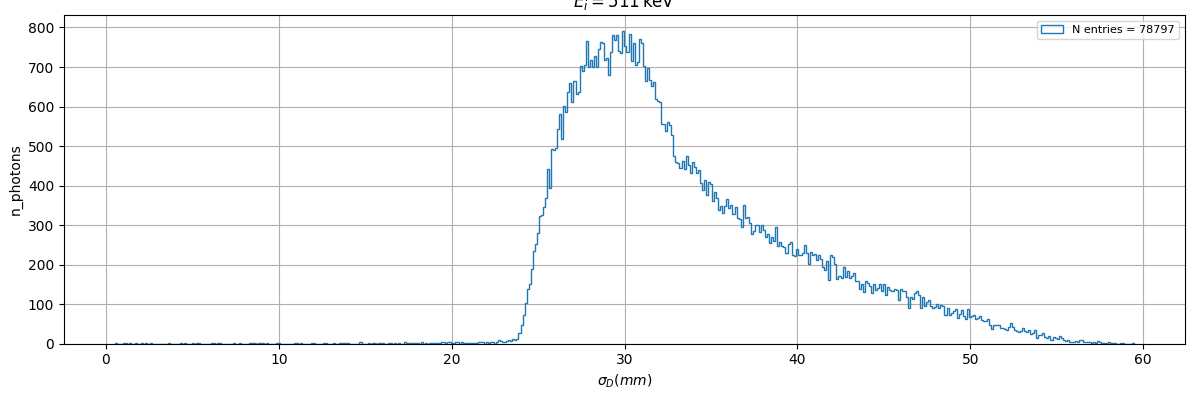

In [91]:
#filt = r_filt
sigma_D_val = sigma_D(r1_s_loc[filt],delta_loc[filt],edep1[filt],
                        theta[filt],beta[filt],
                        sigma_par,sigma_perp,sigma_E, meta)
plt.clf()
#plt.figure(figsize=(3.5, 3.5))
counts, bins, _ = plt.hist(sigma_D_val, bins=500, histtype='step', label = fr'N entries = {len(sigma_D_val)}')
plt.xlabel(r'$\sigma_D(mm)$')
#plt.xlim(0,25)
plt.grid(True)
plt.title(rf"$E_i = {meta['sourceEnergy']} \,\mathrm{{keV}}$ ")
plt.ylabel('n_photons')
plt.legend(fontsize=8,loc = 'upper right')
plt.savefig("sigma_D_750keV.pdf")
plt.show()
